In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
#generate the dataset
BATCHSIZE = 32
def generate_data(numb_samples, seq_length):
  targets = [np.random.randint(low=0, high=10, size = 2) for i in range(numb_samples)]
  sequences = [np.random.randint(low=0,high=10, size= seq_length) for i in range(numb_samples)]
  
  #Calculate the true results for the dataset
  ground_truth = []
  for target,seq in zip(targets,sequences):
    ground_truth.append(calculate_target(target, seq))

  sequences = tf.data.Dataset.from_tensor_slices(sequences)
  sequences = sequences.map(lambda seq: tf.one_hot(seq,10))
  targets = tf.data.Dataset.from_tensor_slices(targets)
  targets = targets.map(lambda t: tf.one_hot(t,10))

  ground_truth = tf.data.Dataset.from_tensor_slices(ground_truth)
  #Combine everything into a dataset
  dataset = tf.data.Dataset.zip((sequences, targets, ground_truth))

  dataset = dataset.batch(BATCHSIZE)
  dataset = dataset.shuffle(BATCHSIZE)
  dataset = dataset.prefetch(8)

  return dataset

In [ ]:
'''Function to calculate which of the two queried target_options appears more often in the sequence'''
def calculate_target(target_options, sequence):
  
  first_target = np.sum(sequence == target_options[0])
  second_target = np.sum(sequence == target_options[1])

  #if the first target number appears more often or equally often as the second we will return 0
  larger_sum = 0
  if first_target < second_target:
    larger_sum = 1

  return larger_sum

In [ ]:
gen = generate_data(1,3)
for elem in gen.take(1):
  print(elem)

(<tf.Tensor: shape=(1, 3, 10), dtype=float32, numpy=
array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(1, 2, 10), dtype=float32, numpy=
array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)


In [ ]:
#LSTM Cell
class LSTMCell(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LSTMCell, self).__init__()

    #gates as dense layers with respective activation function
    self.forget_gate = tf.keras.layers.Dense(units, activation = tf.keras.activations.sigmoid, bias_initializer='ones')
    self.input_gate = tf.keras.layers.Dense(units, activation = tf.keras.activations.sigmoid)
    self.output_gate = tf.keras.layers.Dense(units, activation = tf.keras.activations.sigmoid)
    
    #cell state candidates with tanh
    self.candidates = tf.keras.layers.Dense(units, activation = tf.keras.activations.tanh)

  def call(self, sequence, hidden_state, cell_state):
    #concatenate input and hidden state
    concat_input = tf.concat((tf.cast(hidden_state, dtype=tf.int32), tf.cast(sequence, dtype=tf.int32)), axis = 1)

    #forget part of cell state
    cell_state = cell_state * self.forget_gate(concat_input)

    #compute update for cell state
    update = self.input_gate(concat_input) * self.candidates(concat_input)
    #use input gate and candidates to update cell state
    cell_state = cell_state + update

    #compute new hidden state
    hidden_state = self.output_gate(concat_input) * tf.keras.activations.tanh(cell_state)

    #ouput the hidden state
    return hidden_state, cell_state

In [ ]:
class LSTM(tf.keras.Model):
  def __init__(self):
    super(LSTM, self).__init__()
    self.cell = LSTMCell(units=2)

    #initialize cell_state
    self.cell_state = tf.zeros(shape=(BATCHSIZE, 2))
    self.hidden_state = tf.zeros(shape =(BATCHSIZE, 2))
    self.flatten = tf.keras.layers.Flatten()
    #output which of the target numbers is more likely
    self.read_out = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)
  
  def call(self, data,query):
    #sequence and query concatenation
    for i in range(len(data[1])):
      #concatenate each sequence element with the respective queries
      x = tf.concat((data[:,i,:],tf.reshape(query,[32,20])),axis = 1)

      if(i == 0):
        current_hidden_state, current_cell_state = self.cell(x, self.hidden_state, self.cell_state)
      current_hidden_state, current_cell_state = self.cell(x, current_hidden_state, current_cell_state)

    x = self.flatten(current_hidden_state)
    x = self.read_out(x)
    return x

In [ ]:
def train_step(model, data, query, target, loss_function, optimizer):
  
  with tf.GradientTape() as tape:
    prediction = model(data,query)

    #calculate the loss 
    loss = loss_function(tf.squeeze(prediction), tf.cast(target, dtype=tf.float32)) # solved TypeError: Cannot convert 1e-07 to EagerTensor of dtype int32
    #calculate the accuracy by moving along the vector of targets (per input)
    accuracy = np.sum(np.abs((tf.cast(target, dtype=tf.float32)-tf.squeeze(prediction)))<0.5)/target.shape[0]
    #calculate the gradients for the weights with respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)

  #update the weights
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss, accuracy

In [ ]:
import time
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

In [ ]:
#train
tf.keras.backend.clear_session()

#create data
train_data = generate_data(60000,30)

#model
model = LSTM()

#Define hyperparameters
#How many training epochs do we perform
epochs = 5
#define the learning rate which influences the magnitude with which we update the models parameters
learning_rate = 0.001
loss_function = tf.keras.losses.MSE
optimizer = tf.keras.optimizers.Adam(learning_rate)

running_average_factor = 0.95

steps = []
train_losses = []
train_accuracy = []

for epoch in range(epochs):
  print(epoch, ". epoch --------------------------------------------------------------------------------")
  steps.append(epoch)


  start = time.time()
  original_loss = 0
  original_acc = 0
  for data,query,target in train_data:
    train_loss,train_acc = train_step(model, data, query, target, loss_function, optimizer)

    original_loss = running_average_factor * original_loss + (1-running_average_factor) * train_loss
    original_acc = running_average_factor * original_acc + (1-running_average_factor) * train_acc

  train_losses.append(original_loss)
  train_accuracy.append(original_acc)


  print(f"the training step and test evaluation took {timing(start)} seconds")
  #some sort of plotting
  print("train_loss", original_loss.numpy())
  print("train accuracy", original_acc)


0 . epoch --------------------------------------------------------------------------------
the training step and test evaluation took 185.41 seconds
train_loss 0.23191383
train accuracy 0.6283969569415837
1 . epoch --------------------------------------------------------------------------------
the training step and test evaluation took 182.8 seconds
train_loss 0.22754252
train accuracy 0.6354780465329194
2 . epoch --------------------------------------------------------------------------------
the training step and test evaluation took 180.12 seconds
train_loss 0.22906043
train accuracy 0.6297530676654249
3 . epoch --------------------------------------------------------------------------------
the training step and test evaluation took 180.17 seconds
train_loss 0.2149879
train accuracy 0.6617467184107219
4 . epoch --------------------------------------------------------------------------------
the training step and test evaluation took 179.12 seconds
train_loss 0.21420978
train accur

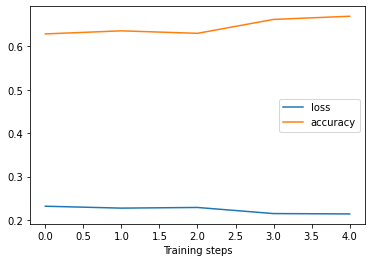

In [ ]:
import matplotlib.pyplot as plt

#do the visualization
#test loss and training loss
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(train_accuracy)
plt.xlabel("Training steps")
plt.legend((line1,line2),("loss","accuracy"))
plt.show()


We assume that it is slowly going to increase with every additional epoch (as seen in this trend), due to timing constraints we were not able to train it for a longer time.

We are pretty sure about our implementation but there might be a bug somewhere in the code anyway. After hours of debugging we feel that we have implemented the general idea and task and have thus completed it to the best of our abilities. 